IMPORT LIBRARIES

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


DATA LOADING

In [ ]:
#Load the different CSV files from Kaggle dataset
apiary_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/Apiary_Information.csv')
hive_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/Hive_Information.csv')
inspection_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/HCC_Inspections.csv')
weather_obs_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/Weather_Observations.csv')
hourly_weather_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/Hourly_Weather.csv')
stations_df = pd.read_csv('/kaggle/input/predicting-honeybee-health-from-hive-and-weather/Predicting Honeybee Health The Healthy Colony Checklist,Hive Scale and Weather Data/Weather_Stations.csv')

DATA MERGING

In [ ]:
#Merge hive and apiary info
hive_merged = hive_df.merge(apiary_df, on='ApiaryID', how='left')
#Merge inspection data with hive info
inspect_merged = inspection_df.merge(hive_merged, on='HiveID', how='left')
#Convert inspection date to datetime
inspect_merged['InsptDate'] = pd.to_datetime(inspect_merged['InsptDate'])

In [ ]:
#Convert weather observation dates to datetime
weather_obs_df['Date'] = pd.to_datetime(weather_obs_df['Date'])
weather_obs_df['Hour'] = pd.to_numeric(weather_obs_df['Obs_Hour'], errors='coerce')

#Merge weather observations with hourly data and stations
weather_full = weather_obs_df.merge(hourly_weather_df, on='ObsID', how='left')
weather_full = weather_full.merge(stations_df, on='StationID', how='left')
weather_full['Date'] = pd.to_datetime(weather_full['Date'])


WEATHER DATA CLEANING

In [ ]:
#Function to convert string of numbers to mean value
def clean_weather_column(series):
    def to_mean(val):
        if isinstance(val, str):
            try:
                nums = [float(x) for x in val.strip().split()]
                return np.mean(nums) if nums else np.nan
            except:
                return np.nan
        elif isinstance(val, (int, float)):
            return val
        return np.nan
    return series.apply(to_mean)

#Clean columns
for col in ['Temperature', 'Humidity', 'Wind_Speed', 'Pressure', 'Dew_Point']:
    weather_full[col] = clean_weather_column(weather_full[col])


In [ ]:
#Aggregate daily weather per city
daily_weather = weather_full.groupby(['Date', 'Station_City']).agg({
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Wind_Speed': 'mean',
    'Pressure': 'mean',
    'Dew_Point': 'mean'
}).reset_index()

In [ ]:
#Merge inspection data with daily weather
final_df = inspect_merged.merge(
    daily_weather,
    left_on=['InsptDate', 'City'],
    right_on=['Date', 'Station_City'],
    how='left'
)

final_df.drop(columns=['Date', 'Station_City'], inplace=True)

FEATURE & TARGET SELECTION

In [31]:
final_df = final_df.dropna(subset=['Bees'])  # target must be present
target = 'Bees'
features = [
    'City', 'State', 'Temperature', 'Humidity', 'Wind_Speed', 'Pressure', 'Dew_Point',
    'Brood', 'Queen', 'Food', 'Stressors', 'Space'
]

X = final_df[features]
y = final_df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
categorical_features = ['City', 'State']
numeric_features = ['Temperature', 'Humidity', 'Wind_Speed', 'Pressure', 'Dew_Point',
                    'Brood', 'Queen', 'Food', 'Stressors', 'Space']

from sklearn.impute import SimpleImputer

#Numeric: median imputation + scaling
#Impute missing numeric values with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Categorical: imputation + one-hot encoding
#Impute missing categorical values with 'missing', then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both in a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#STACKED MODEL SETUP

#Base learners
base_learners = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=50, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

#Meta learner
meta_learner = MLPClassifier(hidden_layer_sizes=(30,), max_iter=300, random_state=42)

#Full stacking pipeline
stacked_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        passthrough=True,
        cv=5
    ))
])

In [ ]:
#Train the model
stacked_pipeline.fit(X_train, y_train)

#Predict
y_pred = stacked_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Stacked Model Test Accuracy: {acc:.3f}")

Stacked Model Test Accuracy: 0.895


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


EVALUATION METRICS

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 30  35]
 [ 15 398]]
              precision    recall  f1-score   support

           0       0.67      0.46      0.55        65
           1       0.92      0.96      0.94       413

    accuracy                           0.90       478
   macro avg       0.79      0.71      0.74       478
weighted avg       0.88      0.90      0.89       478



In [35]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Basic scores
print("Evaluation Metrics:")
print(f"Accuracy       : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision      : {precision_score(y_test, y_pred):.3f}")
print(f"Recall         : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score       : {f1_score(y_test, y_pred):.3f}")

#For ROC AUC, ensure probabilities are available
if hasattr(stacked_pipeline, "predict_proba"):
    y_proba = stacked_pipeline.predict_proba(X_test)[:, 1]
    print(f"ROC AUC Score  : {roc_auc_score(y_test, y_proba):.3f}")


Evaluation Metrics:
Accuracy       : 0.895
Precision      : 0.919
Recall         : 0.964
F1 Score       : 0.941
ROC AUC Score  : 0.863


VISUALIZATIONS

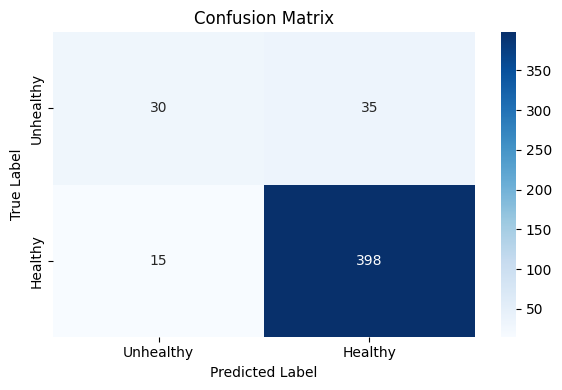

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Unhealthy', 'Healthy'],
            yticklabels=['Unhealthy', 'Healthy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


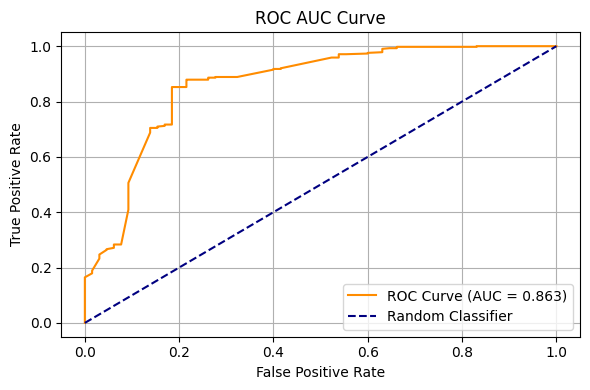

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

#Get predicted probabilities for the positive class (1 = Healthy)
y_proba = stacked_pipeline.predict_proba(X_test)[:, 1]

#Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

#Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
